In [1]:
#import packages
import pandas as pd
import datetime
import os
import xmltodict
import urllib.request
import gzip
import numpy as np
import copy

### active sitemaps

In [2]:
#read in active sitemaps
basepath = '/Users/sd363/Desktop/crowdfunding/data/sitemaps_active/'

sitemaps_active_list = []

for filename in os.listdir(basepath):
    if filename.endswith(".gz"): 
        with gzip.open(basepath + filename, 'r') as fd:
            gz = fd.read()
            sitemaps_active_list.append(xmltodict.parse(gz))

In [3]:
#define function to extract info from sitemap
def getSitemapInfo(sitemap):
    sitemapinfo = []
    for i in range(len(sitemap['urlset']['url'])):
        url = sitemap['urlset']['url'][i]['loc']
        lastmod = sitemap['urlset']['url'][i]['lastmod']
        sitemapinfo.append([url, lastmod])
    return sitemapinfo

In [4]:
#store in dataframe
sitemaps_active = pd.DataFrame()
for sitemap in sitemaps_active_list:
    sitemaps_active = sitemaps_active.append(getSitemapInfo(sitemap))

In [5]:
#rename columns
sitemaps_active = sitemaps_active.rename(columns={0: "url", 1: "last-mod"})

### inactive sitemaps

In [6]:
#read in inactive sitemaps
basepath = '/Users/sd363/Desktop/crowdfunding/data/sitemaps_inactive/'

sitemaps_inactive_list = []

for filename in os.listdir(basepath):
    if filename.endswith(".gz"): 
        with gzip.open(basepath + filename, 'r') as fd:
            gz = fd.read()
            sitemaps_inactive_list.append(xmltodict.parse(gz))

In [7]:
#delete first sitemap (corresponds to sitemap35) because it is throwing an index error
sitemaps_inactive_list = sitemaps_inactive_list[1:]

In [8]:
#store in dataframe
sitemaps_inactive = pd.DataFrame()
for sitemap in sitemaps_inactive_list:
    sitemaps_inactive = sitemaps_inactive.append(getSitemapInfo(sitemap))

In [9]:
#rename columns
sitemaps_inactive = sitemaps_inactive.rename(columns={0: "url", 1: "last-mod"})

### combined sitemaps and convert urls to include /f/

In [10]:
sitemaps_combined = sitemaps_active.append(sitemaps_inactive)

In [11]:
sitemaps_combined_no_fix = sitemaps_combined[sitemaps_combined['url'].str.contains('https://www.gofundme.com/f/')]

In [12]:
sitemaps_combined_to_fix = sitemaps_combined[~sitemaps_combined['url'].str.contains('https://www.gofundme.com/f/')]

In [13]:
new_urls = copy.deepcopy(sitemaps_combined_to_fix['url'].str.replace('https://www.gofundme.com/', 'https://www.gofundme.com/f/'))

In [14]:
sitemaps_combined_to_fix.loc[:,'url'] = new_urls.loc[::]

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [15]:
sitemaps_combined = sitemaps_combined_no_fix.append(sitemaps_combined_to_fix)

In [16]:
urls_to_fix = []
for url in sitemaps_combined['url']:
    if 'https://www.gofundme.com/f/' not in url:
        urls_to_fix.append(url)

In [17]:
urls_to_fix

['http://fundraising.bensfriends.org/1hggp8',
 'http://fundraising.bensfriends.org/1hb3fg',
 'http://fundraising.bensfriends.org/1hb3fg',
 'http://fundraising.bensfriends.org/t64dus',
 'http://fundraising.bensfriends.org/t64dus']

In [18]:
sitemaps_combined = sitemaps_combined[~sitemaps_combined['url'].isin(urls_to_fix)]

In [19]:
urls_to_fix = []
for url in sitemaps_combined['url']:
    if 'https://www.gofundme.com/f/' not in url:
        urls_to_fix.append(url)

In [20]:
urls_to_fix

[]

### spit combined

In [21]:
#randomize order of urls
sitemaps_combined = sitemaps_combined.sample(frac=1).reset_index(drop=True)

In [24]:
n = 1000  #chunk row size
list_df = [sitemaps_combined[i:i+n] for i in range(0,sitemaps_combined.shape[0],n)]

In [27]:
os.chdir("sitemaps/")

In [28]:
for i in range(len(list_df)):
    df = list_df[i]
    filename = "sitemaps_combined_" + str(i) + ".csv"
    df.to_csv(filename)

### date analysis

In [3]:
basepath = '/Users/sd363/Desktop/crowdfunding/data/'

li = []

for filename in os.listdir(basepath):
    df = pd.read_csv(basepath + filename, index_col=None, header=0)
    li.append(df)
    

frame = pd.concat(li, axis=0, ignore_index=True)

In [8]:
"2011-10-10".split('-')[0]

'2011'

In [16]:
frame['year'] = [x.split('-')[0] for x in frame['last-mod']]

In [18]:
frame['year'] = frame['year'].astype(str).astype(int)

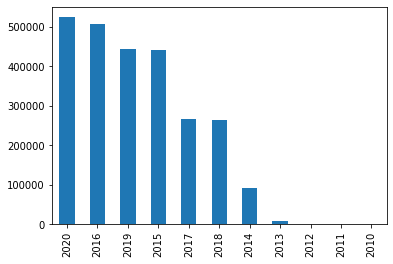

In [20]:
frame['year'].value_counts().plot(kind='bar')